In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from tensorflow.keras import backend as K
from tensorflow.keras.utils import CustomObjectScope

In [2]:
prev_frame_time = 0
new_frame_time = 0

H = 256
W = 256

In [3]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("../my-models/mobilenetv3_unet_single_frame.h5")

In [5]:
imgBg = cv2.imread("../bg/1.jpg")
listImg = os.listdir("../bg")
indexImg = 0

imgList = []
for imgPath in listImg:
    img = cv2.imread(f'../bg/{imgPath}')
    imgList.append(img)

myframes = []
input_frames = []
loop_count = 0
    
    
cap = cv2.VideoCapture(0)


# loop through frame
while cap.isOpened():
    rret, frame = cap.read()

    h, w, _ = frame.shape
    ori_frame = frame

    frame = cv2.resize(frame, (W, H))
    frame = np.expand_dims(frame, axis=0)
    frame = frame / 255.0
    

    mask = model.predict(frame)[0]
    mask = cv2.resize(mask, (w, h))
    mask = mask > 0.5
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    photo_mask = mask
    background_mask = np.abs(1-mask)

    masked_frame = ori_frame * photo_mask

    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    background_mask = background_mask * imgList[indexImg]
    final_frame = masked_frame + background_mask
    final_frame = final_frame.astype(np.uint8)

    font = cv2.FONT_HERSHEY_SIMPLEX
    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps = str(fps)
    
    cv2.putText(final_frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
    
    
    while(loop_count < 4):
        input_frames.append(frame)
        myframes.append(final_frame)
        loop_count = loop_count + 1
        
    cv2.imshow('Bg replacement', final_frame)

    # Break loop outcome
    key = cv2.waitKey(1)
    if key == ord('a'):
        if indexImg > 0:
            indexImg -= 1
    elif key == ord('d'):
        if indexImg < len(imgList) - 1:
            indexImg += 1
    elif key == ord('q'):
        break

# Releases webcam or caputer device
cap.release()
# Closes imshow frame
cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


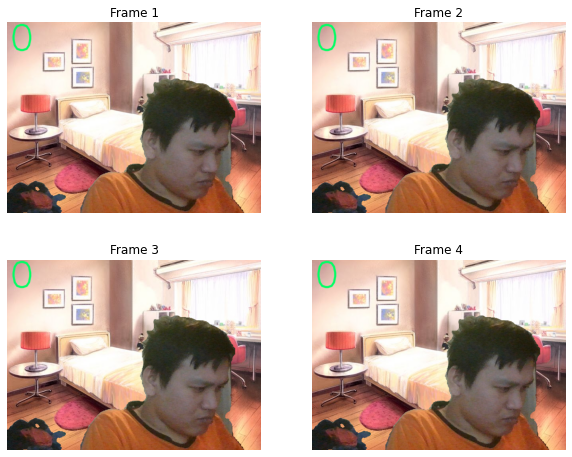

In [6]:
count = 0
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for idx, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(myframes[count], cv2.COLOR_BGR2RGB))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
    count = count + 1

plt.show()

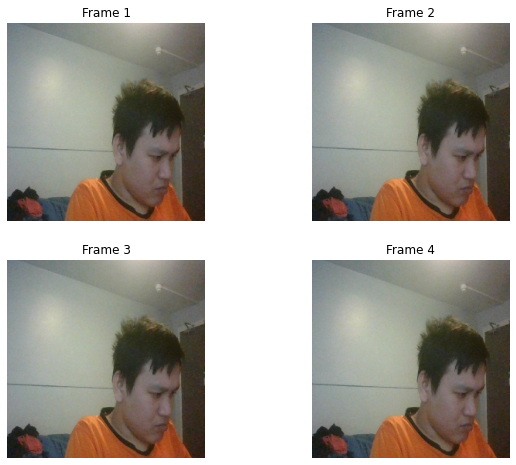

In [7]:
myframes = input_frames

count = 0
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for idx, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor((myframes[count][0]*255).astype(np.uint8),cv2.COLOR_BGR2RGB))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
    count = count + 1

plt.show()